In [1]:
import hydrofunctions as hf
import pandas as pd
import numpy as np
from zipfile import ZipFile
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")

In [25]:
river='Big_R'

location = (42.601817, -80.498078)

In [26]:
WSC_STATIONS = pd.read_pickle('data/WSC_STATIONS')
WSC_FLOWS = pd.read_pickle('data/WSC_FLOWS')
WSC_STATIONS = WSC_STATIONS[WSC_STATIONS.Flow == True]

PWQMN = pd.read_pickle('data/PWQMN')

elem = 'PHOSPHORUS,UNFILTERED TOTAL'
PWQMN = PWQMN[PWQMN["PARM DESCRIPTION"]==elem]
PWQMN.loc[PWQMN.UNITS=='MICROGRAM PER LITER', "RESULT"] = PWQMN.RESULT/1000

PWQMN_LOC = pd.read_excel('../../measurements/PWQMN/PWQMN Locations.xlsx')

GLNI = pd.read_excel('../../measurements/GLNI/Canadian_Tributaries_concentrations_Serghei.xlsx', sheet_name='Data_GLNI_Erie tribs')

elem_name='Phosphorus total'

GLNI = GLNI[GLNI.VariableCommonName==elem_name]

GLNI.SiteName.unique()

delta = 0.5
near_stations = WSC_STATIONS[(WSC_STATIONS.LATITUDE>location[0]-delta) & (WSC_STATIONS.LATITUDE<location[0]+delta) &
                     (WSC_STATIONS.LONGITUDE>location[1]-delta) & (WSC_STATIONS.LONGITUDE<location[1]+delta)]


Flow_IDS = [[st, False] for st in near_stations.STATION_NUMBER.unique()] 

near_pwqmn_stations = PWQMN_LOC[(PWQMN_LOC.LATITUDE>location[0]-delta) & (PWQMN_LOC.LATITUDE<location[0]+delta) &
                     (PWQMN_LOC.LONGITUDE>location[1]-delta) & (PWQMN_LOC.LONGITUDE<location[1]+delta)]


near_glni_stations = GLNI[(GLNI.Latitude>location[0]-delta) & (GLNI.Latitude<location[0]+delta) &
                     (GLNI.Longitude>location[1]-delta) & (GLNI.Longitude<location[1]+delta)]

near_glni_stations = near_glni_stations[['SiteCode','Latitude','Longitude']]

near_glni_stations = near_glni_stations.rename(index=str, columns={'SiteCode':'STATION', 'Latitude':'Latitude'.upper(), 'Longitude':'Longitude'.upper()})


PWQMN_IDS = [[st, False] for st in set(PWQMN.STATION.unique()).intersection(near_pwqmn_stations.STATION.unique())]

all_near_stations = pd.DataFrame({'STATION':[], 'LONGITUDE':[], 'LATITUDE':[]})

near_stations = near_stations[['STATION_NUMBER', 'LONGITUDE', 'LATITUDE']]

near_stations = near_stations.rename(index=str, columns={'STATION_NUMBER':'STATION'})


near_pwqmn_stations = near_pwqmn_stations[['STATION', 'LONGITUDE', 'LATITUDE']]

all_near_stations = pd.concat([near_stations, near_pwqmn_stations, near_glni_stations])



/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [43]:
Show_IDS = [[st, False] for st in all_near_stations.STATION.unique()] 

In [55]:
import folium
# import folium.plugins as plugins
from folium.plugins import MiniMap
from folium.plugins.beautify_icon import BeautifyIcon
from folium.features import DivIcon



# m = folium.Map(width=500,height=300, location=location, zoom_start=11.,tiles="OpenStreetMap", attr='Global Water Futures')
m = folium.Map(width=700,height=500, 
                location=location,
               control_scale = True,
                 zoom_start=11.5,
               zoom_control=False,
                 tiles='https://tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=34dad269f6ab438c9534def56b86fa5f',
                 API_key='34dad269f6ab438c9534def56b86fa5f',
                attr='Global Water Futures')

# show all Flow
# for index, st_dic in enumerate(Flow_IDS):
#     st = st_dic[0]
# #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
# #     if N>10:
#     st_df = near_stations[near_stations.STATION == st]
#     folium.Marker(location=[st_df.LATITUDE.values[0], 
#                             st_df.LONGITUDE.values[0]], 
#                               popup=folium.Popup(html=st_df.STATION.values[0],
#                             show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='gray')
#                  ).add_to(m)

# # show all
if 0:
    for index, st_dic in enumerate(Show_IDS):
        st = st_dic[0]
    # #     N = df[df.MonitoringLocationIdentifier==st].shape[0]
    # #     if N>10:
        st_df = all_near_stations[all_near_stations.STATION == st]
        folium.Marker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], 
                                  popup=folium.Popup(html=str(st_df.STATION.values[0]),
                                show=False, max_width=10), icon=folium.Icon(icon='arrow-down', color='gray')
                     ).add_to(m)
else:
    Show_IDS = [
    [16012400302, False],
    [16012401002, True],
    ["ON02GC1200", True],
    ["02GC007", True],
    [16012401102, True],
    ]



    for index, st_dic in enumerate(Show_IDS):
        st = st_dic[0]
        print(st)
        if st_dic[1]:
            clr='#f44242'
        else:
            clr='#0b15c4'
        st_df = all_near_stations[all_near_stations.STATION == st]
        folium.CircleMarker(location=[st_df.LATITUDE.values[0], 
                                st_df.LONGITUDE.values[0]], radius=23, 
                            fill=True, fill_color='white',
                                color = clr,fill_opacity=1,
                           weight=5).add_to(m)
        if not index+1 in [3,4]:
            folium.map.Marker(
    #         location=[st_df.LATITUDE.values[0]+0.0235,st_df.LONGITUDE.values[0]-0.1026], # 10 km
    #         location=[st_df.LATITUDE.values[0]+0.0135,st_df.LONGITUDE.values[0]-0.0526], # 5km
            location=[st_df.LATITUDE.values[0]+0.0065,st_df.LONGITUDE.values[0]-0.026], # 2km
#             location=[st_df.LATITUDE.values[0]+0.003,st_df.LONGITUDE.values[0]-0.013], # 1km
    #         location=[st_df.LATITUDE.values[0]+0.0015,st_df.LONGITUDE.values[0]-0.0064], # 500m
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 24pt;text-align: center;vertical-align: middle">{}</div>'.format(index+1),
                )
            ).add_to(m)




m




# 16012400302
# 16012401002
# ON02GC1200
# 02GC007
# 16012401102

16012400302
16012401002
ON02GC1200
02GC007
16012401102


In [56]:
selected_stations = [s[0] for s in Show_IDS]

In [57]:
TP_1 = PWQMN[PWQMN.STATION.isin(selected_stations)][['DATE', 'RESULT','STATION']]
TP_1['RESULT'] = pd.to_numeric(TP_1['RESULT'])
TP_1['RESULT'] = TP_1['RESULT']*(TP_1['RESULT']<20)

TP_2 = GLNI[GLNI.SiteCode.isin(selected_stations)] # [['DATE', 'RESULT','STATION']]
TP_2 = TP_2[['SampleDateTime', 'Value', 'SiteCode']]
TP_2 = TP_2.rename(index=str, columns={'SampleDateTime':'DATE', 'Value':'RESULT', 'SiteCode':'STATION'})

TP = pd.concat([TP_1, TP_2])


TP['RESULT'] = pd.to_numeric(TP['RESULT'])

pt = sns.color_palette("colorblind", len(selected_stations))



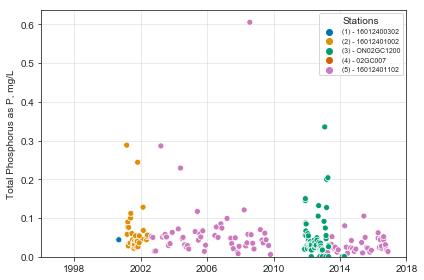

In [58]:
## fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

ax = sns.scatterplot(x='DATE', y='RESULT', data=TP, hue_order=selected_stations, hue='STATION', palette=pt, markers=True)
leg = ["({}) - {}".format(i+1,st) for i, st in enumerate(selected_stations)]

leg_handles = ax.get_legend_handles_labels()[0]
ax.legend(leg_handles[1:], leg, title='Stations', fontsize='x-small', loc='best')

# ax.legend(['(1) - HTLP (NCWQR)'], title='Stations', fontsize='x-small', loc=2)

plt.ylim(0,None)
plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.ylabel("Total Phosphorus as P, mg/L")
plt.xlabel("")
plt.tight_layout()
plt.savefig('One_by_one/Canada/'+river+'/'+river+'_TP.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables/img/Western/Canada/'+river+'/'+river+'_TP.pdf')



In [59]:
print(TP.groupby('STATION')["RESULT"].describe().reindex(selected_stations).round(2).to_latex())
      

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &   std &   min &   25\% &   50\% &   75\% &   max \\
STATION     &        &       &       &       &       &       &       &       \\
\midrule
16012400302 &    2.0 &  0.04 &  0.00 &  0.04 &  0.04 &  0.04 &  0.04 &  0.04 \\
16012401002 &   33.0 &  0.07 &  0.06 &  0.02 &  0.04 &  0.05 &  0.08 &  0.29 \\
ON02GC1200  &   71.0 &  0.05 &  0.06 &  0.00 &  0.02 &  0.03 &  0.05 &  0.34 \\
02GC007     &    NaN &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN &   NaN \\
16012401102 &   96.0 &  0.05 &  0.07 &  0.01 &  0.02 &  0.04 &  0.05 &  0.60 \\
\bottomrule
\end{tabular}



In [60]:
selected_stations

[16012400302, 16012401002, 'ON02GC1200', '02GC007', 16012401102]

In [61]:
master_stations = [st[0] for st in Show_IDS if st[1]]
# master_stations = selected_stations
master_st_df = TP[TP.STATION.isin(master_stations)]
master_st_df['USGSPCode'] = 0
master_st_df.shape

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(200, 4)

In [62]:
master_st_df.DATE = master_st_df.DATE.dt.date
# = pd.to_date(master_st_df.DATE, format="%Y-%m-%d")
# master_st_df

/Users/imarkelo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [63]:
master_st_df[[
    'DATE','USGSPCode', 'RESULT']].groupby('DATE').mean().reset_index().sort_values('DATE').to_csv(
    'One_by_one/Canada/'+river+'/TP_'+river+'iver_data.csv', index=False)

### Discharge

In [64]:
river

'Big_R'

In [65]:
site = '02GC007'
discharge = WSC_FLOWS[WSC_FLOWS.index>datetime.datetime(1996,1,1)][site].to_frame()

discharge = discharge.reset_index()
discharge = discharge.rename(index=str, columns={site:'Discharge, cms', 'index':'Date'})
discharge['Source'] = site

discharge['Flow, CFS'] = discharge['Discharge, cms']/0.028

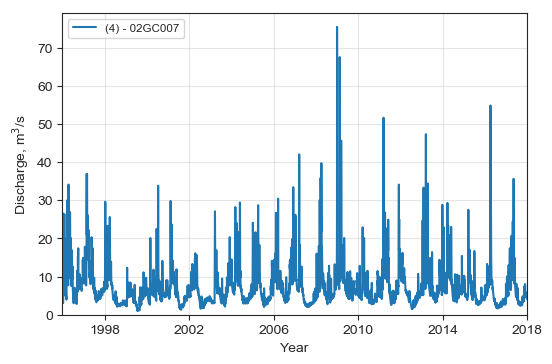

In [66]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
ax=sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source',ax=ax)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


ax.legend(['({}) - {}'.format(selected_stations.index(site)+1, site)], loc=2, fontsize='small')
ax.set_ylim(0,None)
ax.set_xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
ax.grid(alpha=0.5)
ax.set_ylabel("Discharge, m$^3$/s")
ax.set_xlabel("Year")

# axins = zoomed_inset_axes(ax, 8, loc='upper center')
# sns.lineplot(x='Date', y='Discharge, cms', data=discharge, hue='Source', ax=axins,zorder=10)
# axins.set_xlim(datetime.datetime(2010,4,1), datetime.datetime(2010,6,1)) # apply the x-limits
# axins.set_ylim(0, 10) # apply the y-limits
# plt.yticks(visible=False)
# plt.xticks(visible=False)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig('One_by_one/Canada/'+river+'/'+river+'_Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables/img/Western/Canada/'+river+'/'+river+'_Q.pdf')

In [67]:
discharge[['Date', 'Flow, CFS']].to_csv('One_by_one/Canada/'+river+'/Flow_'+river+'_CFS.csv', index=False)

### Egret

In [68]:
river

'Big_R'

In [69]:

EGRET_Daily = pd.read_csv('/Users/imarkelo/git/Great-Lakes-Data/post_proc_scripts/Loadings Canada 2/One_by_one/Canada/'+river+'/EGRET Result/TP/'+river+'iver_TP_Daily.csv')
EGRET_Sample = pd.read_csv('/Users/imarkelo/git/Great-Lakes-Data/post_proc_scripts/Loadings Canada 2/One_by_one/Canada/'+river+'/EGRET Result/TP/'+river+'iver_TP_Sample.csv')


EGRET_Sample['Fx_Hat'] = EGRET_Sample['Q']*60*60*24*1000 * EGRET_Sample['ConcHat']/1000/1000
EGRET_Sample['Fx_C'] = EGRET_Sample['Q']*60*60*24*1000 * EGRET_Sample['ConcAve']/1000/1000


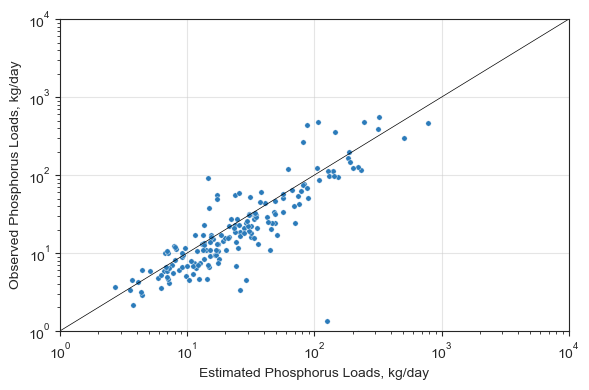

In [70]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)
sns.scatterplot(y='Fx_C', 
                x='Fx_Hat',
                data=EGRET_Sample,
                s=15,
                linewidth=0.3, ax=ax,
               color=sns.color_palette("Blues")[4])
# plt.legend("")
ax.set_xscale('log')
ax.set_yscale('log')
plt.plot([-100,1000000],[-100,1000000], 'k', lw=0.5)
plt.xlim(1,10000)
plt.ylim(1,10000)
# plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.xlabel("Estimated Phosphorus Loads, kg/day")
plt.ylabel("Observed Phosphorus Loads, kg/day")
# plt.xlabel("")
plt.tight_layout()
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables/img/Western/Canada/'+river+'/'+river+'_FvsF.pdf')


In [71]:
EGRET_Daily['FluxYearMTA'] = EGRET_Daily['FluxDay']*365/1000
EGRET_Daily['Fx_SE'] = (np.exp(EGRET_Daily['SE']+EGRET_Daily['yHat']) * EGRET_Daily['Q']*60*60*24*1000/1000/1000/1000-np.exp(EGRET_Daily['yHat']) * EGRET_Daily['Q']*60*60*24*1000/1000/1000/1000)*365
EGRET_Daily_an = EGRET_Daily.groupby('waterYear').mean().reset_index()


EGRET_Daily_an

,waterYear,Unnamed: 0,Q,Julian,Month,Day,DecYear,MonthSeq,i,LogQ,Q7,Q30,yHat,SE,ConcDay,FluxDay,FNConc,FNFlux,FluxYearMTA,Fx_SE
0,1996,137.0,9.550045,53462.0,5.021978,138.000000,1996.375797,1757.021978,137.0,2.072408,9.551319,9.660388,-2.188902,0.439418,0.158206,182.590961,0.121533,147.959593,66.645701,30.431872
1,1997,456.0,10.012083,53781.0,6.526027,183.838356,1997.248146,1767.501370,456.0,2.175550,10.101178,10.243181,-2.094929,0.457983,0.157821,183.019468,0.112525,136.273697,66.802106,30.601726
2,1998,821.0,7.170701,54146.0,6.526027,183.838356,1998.248059,1779.501370,821.0,1.777915,7.185125,7.248792,-2.630629,0.450310,0.091568,81.363565,0.104757,124.661677,29.697701,13.852925
3,1999,1186.0,3.722308,54511.0,6.526027,183.838356,1999.248059,1791.501370,1186.0,1.193398,3.712883,3.690106,-3.384082,0.444603,0.041061,14.595022,0.097655,114.163756,5.327183,2.640855
4,2000,1551.5,6.767665,54876.5,6.513661,183.500000,2000.248661,1803.497268,1551.5,1.804335,6.736102,6.649509,-2.791291,0.469432,0.094827,83.765099,0.091356,104.883677,30.574261,16.090335
5,2001,1917.0,6.305901,55242.0,6.526027,183.838356,2001.248146,1815.501370,1917.0,1.642177,6.348084,6.463776,-2.998294,0.454649,0.064633,50.895121,0.085313,96.188750,18.576719,8.773734
6,2002,2282.0,5.822908,55607.0,6.526027,183.838356,2002.248059,1827.501370,2282.0,1.609064,5.816531,5.808566,-3.116509,0.459962,0.054466,32.669112,0.080033,88.597130,11.924226,5.920119
7,2003,2647.0,5.154414,55972.0,6.526027,183.838356,2003.248059,1839.501370,2647.0,1.518218,5.129272,5.092314,-3.305342,0.471037,0.050912,30.440076,0.075240,81.794024,11.110628,5.471634
8,2004,3012.5,8.371679,56337.5,6.513661,183.500000,2004.248661,1851.497268,3012.5,1.977586,8.398896,8.415957,-2.800503,0.477824,0.080815,78.769704,0.071047,75.873550,28.750942,14.780719
9,2005,3378.0,7.004014,56703.0,6.526027,183.838356,2005.248146,1863.501370,3378.0,1.758461,6.994629,6.993051,-3.120707,0.475221,0.058402,50.766991,0.066933,70.070429,18.529952,9.476275


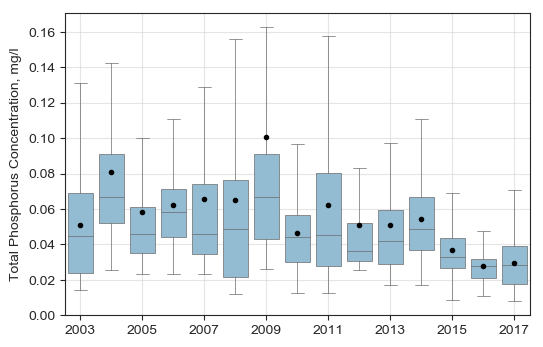

In [72]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

# sns.boxplot(EGRET_Daily['waterYear'], EGRET_Daily['ConcDay'], color=sns.color_palette()[0])

# plt.fill_between(EGRET_Daily_an['waterYear'][5:-1],
#                  np.exp(EGRET_Daily_an['yHat'][5:-1]-EGRET_Daily_an['SE'][5:-1]),
#                  np.exp(EGRET_Daily_an['yHat'][5:-1]+EGRET_Daily_an['SE'][5:-1]), 
#                  color=sns.color_palette()[0], alpha=0.15)
# plt.plot(EGRET_Daily_an['waterYear'][5:-1], EGRET_Daily_an['FluxYearMTA'][5:-1])

# sns.scatterplot(x="waterYear", y="FluxYearMTA",
#                 sizes=(1, 8), linewidth=0.3,
#                 data=EGRET_Daily_an, ax=ax)

meanpointprops = dict(marker='.', markeredgecolor='black', markersize=6,markerfacecolor='black')
ax = sns.boxplot(showmeans=True, linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="ConcDay", 
                 data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2],
                order=range(2003,2018))

# ax = sns.boxplot(showmeans=True, linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="ConcDay", data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2])
# ax.set_yscale('log')
# plt.legend("")
# plt.plot([-100,100],[-100,100], 'k', lw=0.5)
# plt.xlim(2003,2018)
# plt.xlim(6.5, 18.5)
locs, labels = plt.xticks() 
plt.xticks(locs[::2], labels[::2])
plt.ylim(0,None)
# plt.vlines(4.5, 0, 0.6, 'k', '-.', lw=0.7)
# plt.vlines(9.5, 0, 0.6, 'k', '-.', lw=0.7)

# ax.set_xticks([int(x) for x in np.linspace(2003,2017, 8)])

plt.grid(alpha=0.5)
plt.ylabel("Total Phosphorus Concentration, mg/l")
plt.xlabel("")
# fig.autofmt_xdate()
# plt.savefig('One_by_one/Western/US/Portage R/Portage Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables/img/Western/Canada/'+river+'/'+river+'_PC.pdf')




In [73]:
EGRET_Daily_an['Fx_AE'] = (abs(EGRET_Sample['Fx_Hat'] - EGRET_Sample['Fx_C'])/EGRET_Sample['Fx_C']).mean()*EGRET_Daily_an['FluxYearMTA']




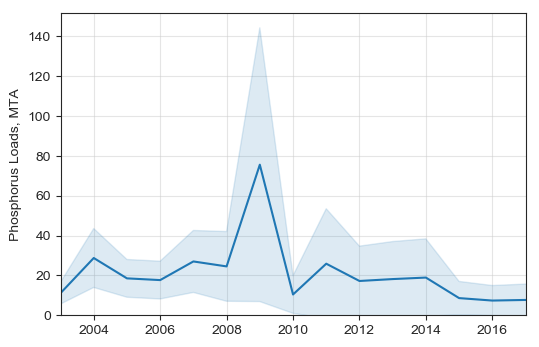

In [75]:
fig,ax=plt.subplots(1,1,figsize=(6,4), dpi=100)

k=None
plt.plot(EGRET_Daily_an['waterYear'][:k], EGRET_Daily_an['FluxYearMTA'][:k], c=sns.color_palette()[0])

# s=12
# plt.plot(EGRET_Daily_an['waterYear'][s:], EGRET_Daily_an['FluxYearMTA'][s:], c=sns.color_palette()[0])

plt.fill_between(EGRET_Daily_an['waterYear'][:k],
                 EGRET_Daily_an['FluxYearMTA'][:k]-EGRET_Daily_an['Fx_SE'][:k],
                 EGRET_Daily_an['FluxYearMTA'][:k]+EGRET_Daily_an['Fx_SE'][:k], 
                 color=sns.color_palette()[0], alpha=0.15)

# plt.fill_between(EGRET_Daily_an['waterYear'][s:],
#                  EGRET_Daily_an['FluxYearMTA'][s:]-EGRET_Daily_an['Fx_SE'][s:],
#                  EGRET_Daily_an['FluxYearMTA'][s:]+EGRET_Daily_an['Fx_SE'][s:], 
#                  color=sns.color_palette()[0], alpha=0.15)



# plt.vlines(2007, 0, 200, 'k', '-.', lw=0.7)
# plt.vlines(2013, 0, 200, 'k', '-.', lw=0.7)


# plt.plot(EGRET_Daily_an['waterYear'][5:-1], EGRET_Daily_an['FluxYearMTA'][5:-1])

# sns.scatterplot(x="waterYear", y="FluxYearMTA",
#                 sizes=(1, 8), linewidth=0.3,
#                 data=EGRET_Daily_an, ax=ax)

# meanpointprops = dict(marker='D', markeredgecolor='black', markersize=1,markerfacecolor=sns.color_palette()[3])
# ax = sns.boxplot(linewidth=0.5, meanprops=meanpointprops, x="waterYear", y="FluxYearMTA", data=EGRET_Daily, showfliers=False, color=sns.color_palette("Blues")[2])
# ax.set_yscale('log')
# plt.legend("")
# plt.plot([-100,100],[-100,100], 'k', lw=0.5)
plt.ylim(0,None)
plt.xlim(2003,2017)
# plt.xticks([int(x) for x in np.linspace(5,19,8)], [int(x) for x in np.linspace(2003,2017, 8)])
# plt.ylim(0,200)
# plt.xlim(datetime.datetime(1996,1,1), datetime.datetime(2018,1,1))
plt.grid(alpha=0.5)
plt.ylabel("Phosphorus Loads, MTA")
plt.xlabel("")
# plt.savefig('One_by_one/Western/US/Portage R/Portage Q.pdf')
plt.savefig('/Users/imarkelo/Google Drive/GDocuments/Lake Erie/Draft/Rivers_tables/img/Western/Canada/'+river+'/'+river+'_PFlux.pdf')


In [76]:
print(EGRET_Daily_an[(EGRET_Daily_an.waterYear<2018) & (EGRET_Daily_an.waterYear>2002)][['waterYear', 'FluxYearMTA','Fx_SE']].round(1).T.to_latex(index=False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
     7  &      8  &      9  &      10 &      11 &      12 &      13 &      14 &      15 &      16 &      17 &      18 &      19 &      20 &      21 \\
\midrule
 2003.0 &  2004.0 &  2005.0 &  2006.0 &  2007.0 &  2008.0 &  2009.0 &  2010.0 &  2011.0 &  2012.0 &  2013.0 &  2014.0 &  2015.0 &  2016.0 &  2017.0 \\
   11.1 &    28.8 &    18.5 &    17.7 &    27.0 &    24.5 &    75.6 &    10.4 &    25.9 &    17.2 &    18.2 &    18.9 &     8.6 &     7.4 &     7.7 \\
    5.5 &    14.8 &     9.5 &     9.5 &    15.6 &    17.5 &    68.7 &     9.4 &    27.6 &    17.5 &    18.8 &    19.4 &     8.4 &     7.5 &     8.0 \\
\bottomrule
\end{tabular}

